In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# 1. Loading data
vle = pd.read_csv("vle.csv")
student_vle = pd.read_csv("studentVle.csv")
student_info = pd.read_csv("studentInfo.csv")

In [13]:
# 2. Combining data
student_vle = student_vle.merge(vle[['id_site', 'activity_type']], on='id_site', how='left')

In [14]:
# 3. Convert date: from the beginning of the course
student_vle['date'] = student_vle['date'].fillna(-1)

In [15]:
# 4. Calculating activity indicators (for each student)
# Calculating total clicks by activity types
activity_pivot = student_vle.pivot_table(
    index='id_student',
    columns='activity_type',
    values='sum_click',
    aggfunc='sum'
).fillna(0)

In [16]:
# Total number of clicks
activity_pivot['total_clicks'] = activity_pivot.sum(axis=1)


In [17]:
# Number of unique days of activity
active_days = student_vle.groupby('id_student')['date'].nunique()
activity_pivot['active_days'] = active_days

# Average number of clicks per day
activity_pivot['avg_clicks_per_day'] = activity_pivot['total_clicks'] / (activity_pivot['active_days'] + 1e-6)

In [18]:
# 5. Attach the final results
student_results = student_info[['id_student', 'final_result']]
features = activity_pivot.merge(student_results, left_index=True, right_on='id_student', how='left')

In [19]:
# 6. Scaling features (without final_result)
X = features.drop(columns=['id_student', 'final_result'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# 7. Clustering (e.g. KMeans on 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
features['cluster'] = kmeans.fit_predict(X_scaled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


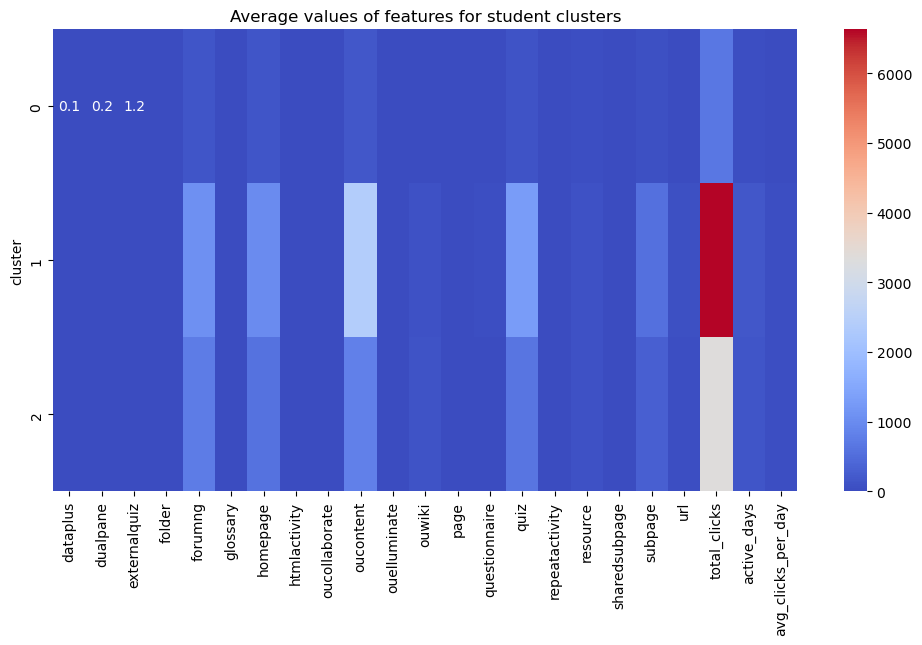

In [21]:
# 8. Visualization: average feature values ​​by clusters
cluster_means = features.groupby('cluster')[X.columns].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Average values ​​of features for student clusters")
plt.show()

In [22]:
# 9. Analysis of academic performance by clusters
result_by_cluster = features.groupby(['cluster', 'final_result']).size().unstack(fill_value=0)
print(result_by_cluster)

final_result  Distinction  Fail  Pass  Withdrawn
cluster                                         
0                    1384  5919  7227       6663
1                     495    73   963         86
2                    1145   727  4168        891


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score


vle = pd.read_csv("vle.csv")
student_vle = pd.read_csv("studentVle.csv")
student_info = pd.read_csv("studentInfo.csv")

# 2. Merge activity_type
student_vle = student_vle.merge(vle[['id_site', 'activity_type']], on='id_site', how='left')
student_vle['date'] = student_vle['date'].fillna(-1)

In [24]:
# 3. Extracting Activity Features
activity_pivot = student_vle.pivot_table(
    index='id_student',
    columns='activity_type',
    values='sum_click',
    aggfunc='sum'
).fillna(0)

activity_pivot['total_clicks'] = activity_pivot.sum(axis=1)
active_days = student_vle.groupby('id_student')['date'].nunique()
activity_pivot['active_days'] = active_days
activity_pivot['avg_clicks_per_day'] = activity_pivot['total_clicks'] / (activity_pivot['active_days'] + 1e-6)

# Behavioural additional features:
# - Activity diversity (number of unique activity types)
activity_pivot['unique_activities'] = (activity_pivot.drop(columns=['total_clicks', 'active_days', 'avg_clicks_per_day']) > 0).sum(axis=1)
# - Activity coefficient: total_clicks / max_clicks_по_типу
activity_pivot['max_type_clicks'] = activity_pivot.drop(columns=['total_clicks', 'active_days', 'avg_clicks_per_day', 'unique_activities']).max(axis=1)
activity_pivot['activity_balance'] = activity_pivot['max_type_clicks'] / (activity_pivot['total_clicks'] + 1e-6)


In [25]:
# 4. Connecting with the learning outcome
student_results = student_info[['id_student', 'final_result']]
features = activity_pivot.merge(student_results, left_index=True, right_on='id_student', how='left')

In [26]:
# 5. Preparing data for clustering
feature_cols = [c for c in features.columns if c not in ['id_student', 'final_result']]
X = features[feature_cols]
X = X.fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

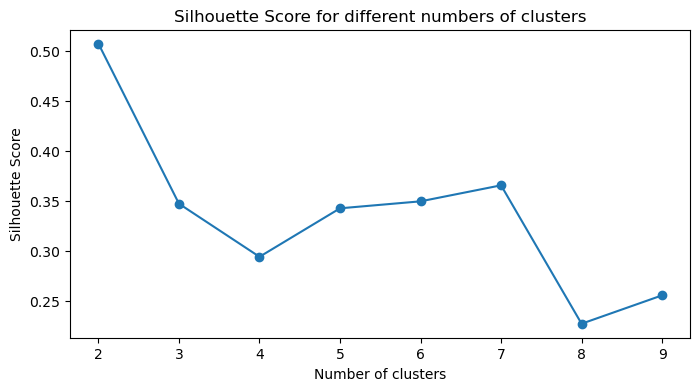

Optimal number of clusters according to silhouette score: 2


In [27]:
# 6. Automatic selection of the number of clusters (silhouette score)
silhouette_scores = []
K_range = range(2, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,4))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

best_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters according to silhouette score: {best_k}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


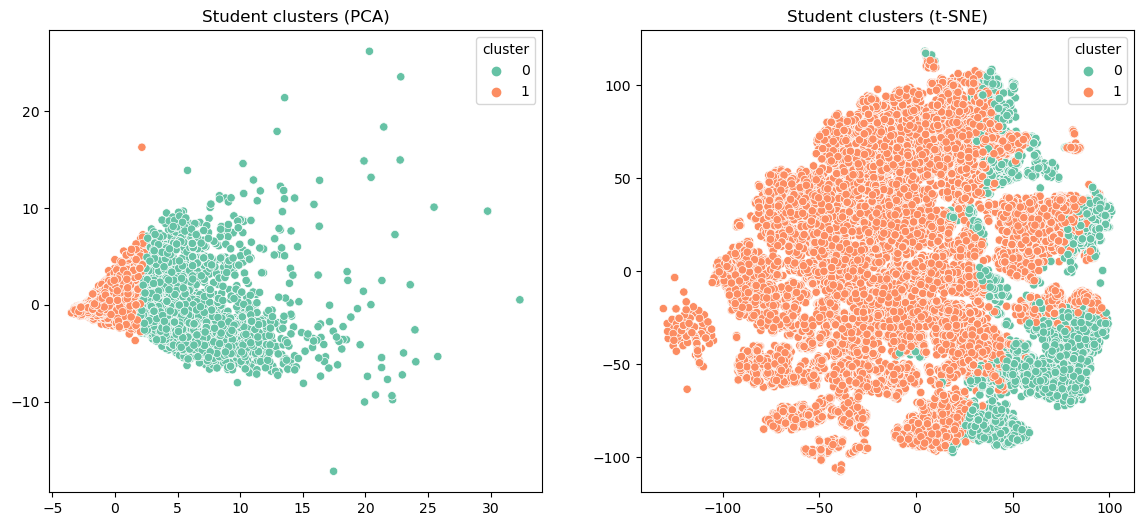

In [28]:
# 7. Clustering (KMeans)
kmeans = KMeans(n_clusters=best_k, random_state=42)
features['cluster'] = kmeans.fit_predict(X_scaled)

# 8. Visualization of clusters in 2D (PCA и t-SNE)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=features['cluster'], palette='Set2')
plt.title('Student clusters (PCA)')

plt.subplot(1,2,2)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=features['cluster'], palette='Set2')
plt.title('Student clusters (t-SNE)')
plt.show()

Average values ​​of features by clusters:
          dataplus  dualpane  externalquiz    folder      forumng  glossary  \
cluster                                                                      
0        9.900242  3.770052      5.021161  0.952640  1019.113462  8.453245   
1        0.168691  0.268897      2.206546  0.068445   180.653820  2.351548   

           homepage  htmlactivity  oucollaborate    oucontent  ...  \
cluster                                                        ...   
0        824.045345      1.097138      10.798670  1529.299476  ...   
1        176.609710      0.192219       3.247347   232.795633  ...   

           resource  sharedsubpage     subpage        url  total_clicks  \
cluster                                                                   
0        102.812576       0.006046  419.010077  65.024990   5145.247279   
1         35.183300       0.006255   83.403043  14.987893    915.106300   

         active_days  avg_clicks_per_day  unique_activities  m

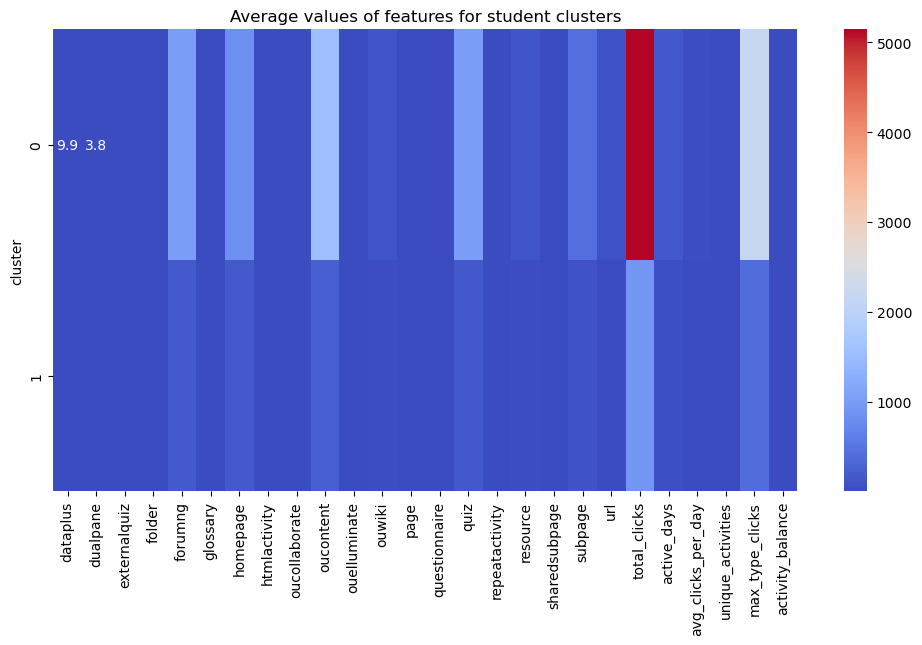

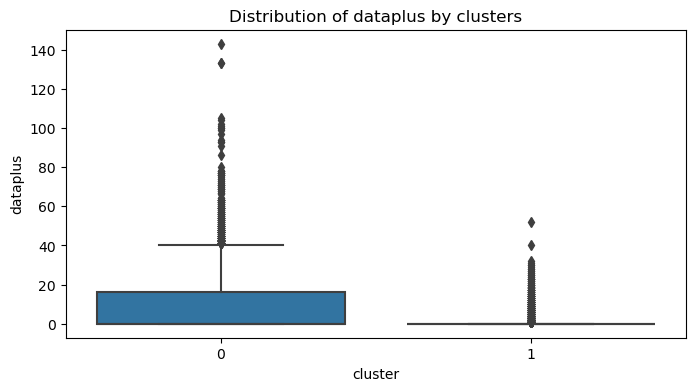

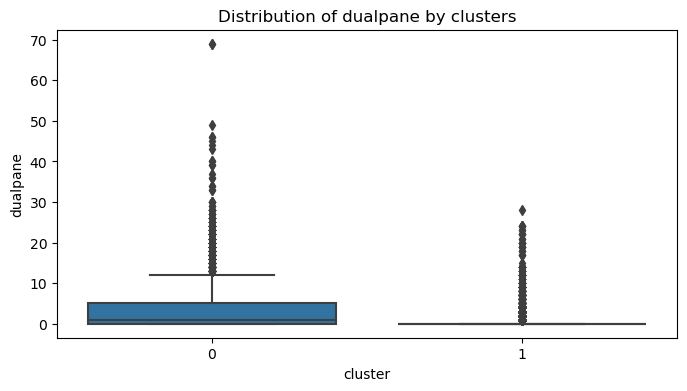

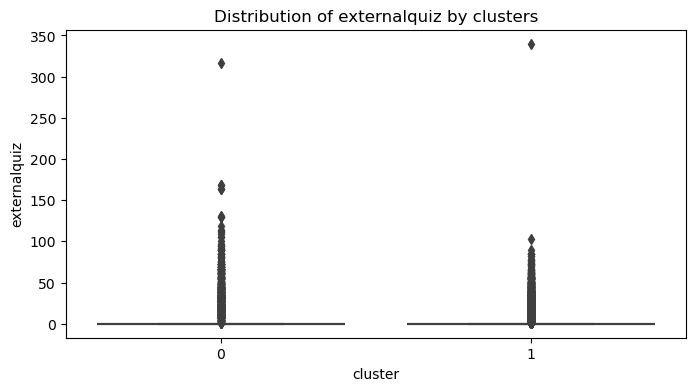

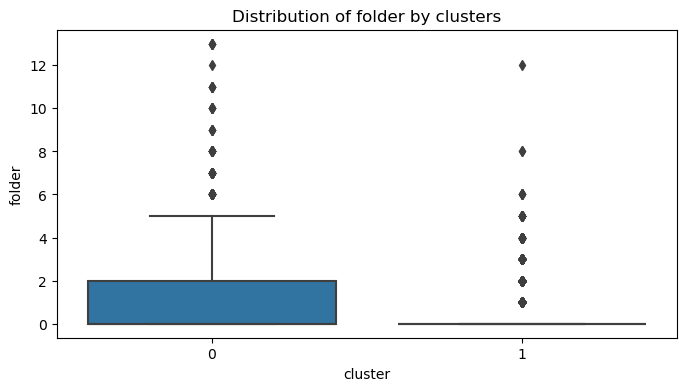

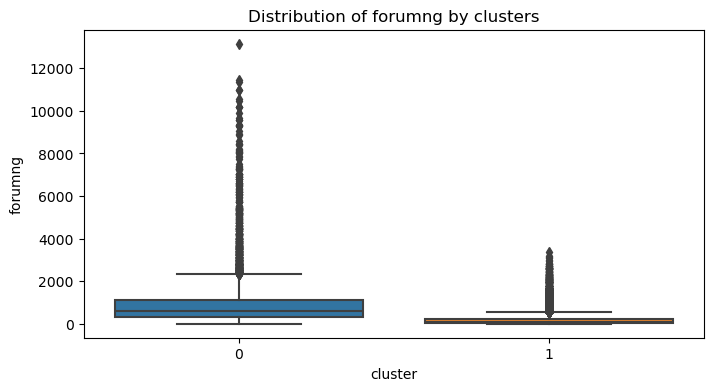

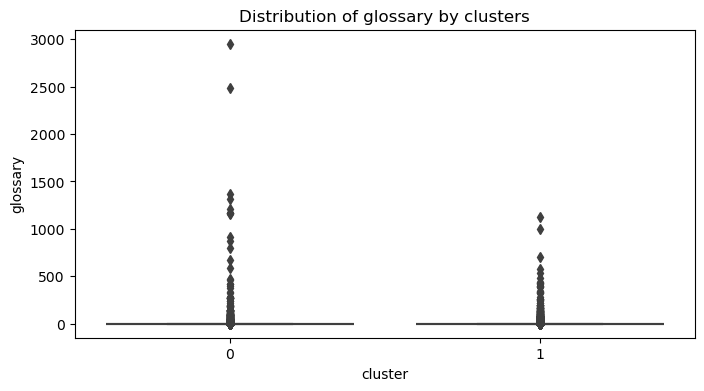

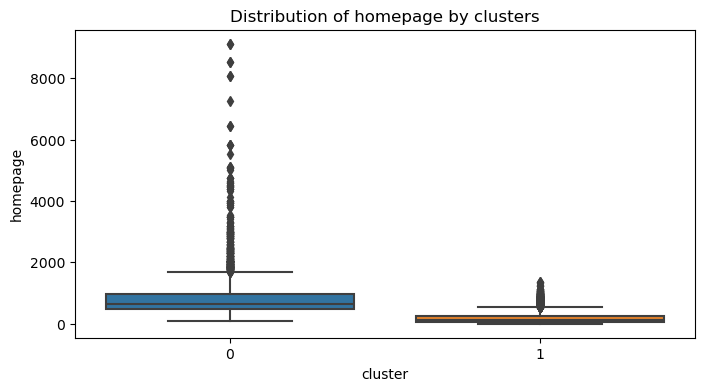

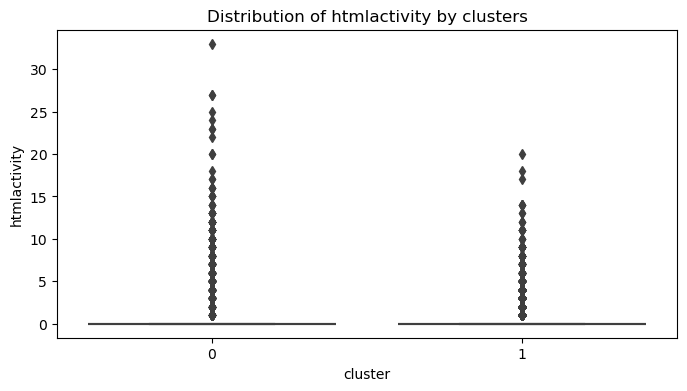

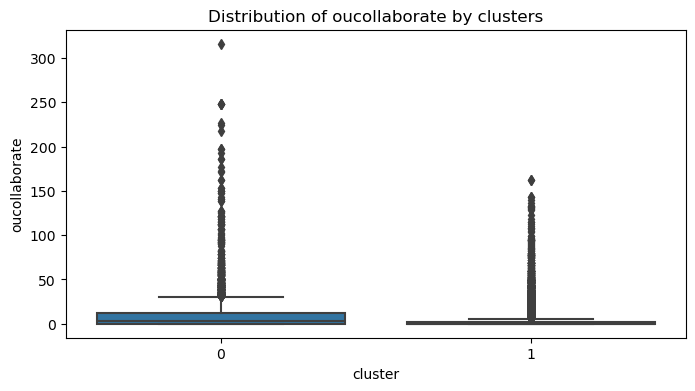

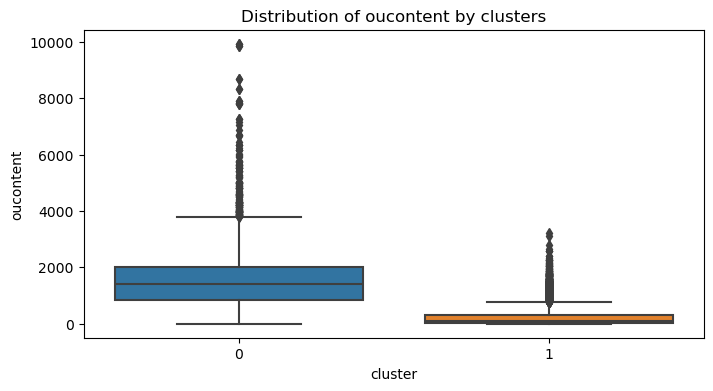

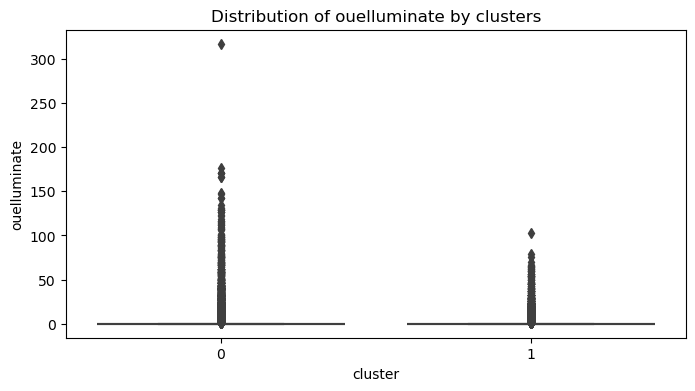

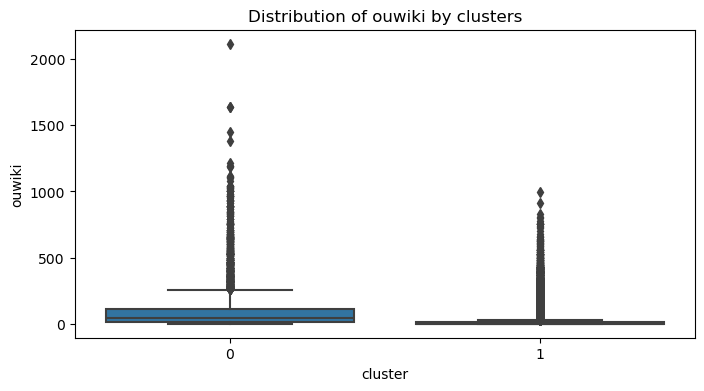

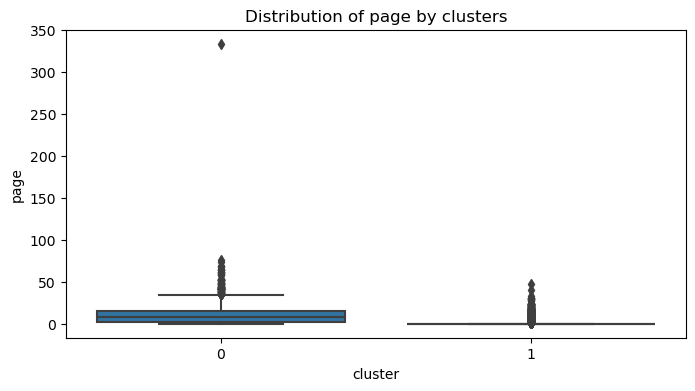

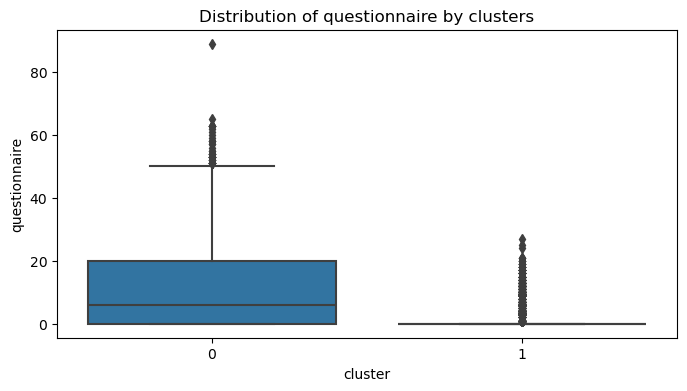

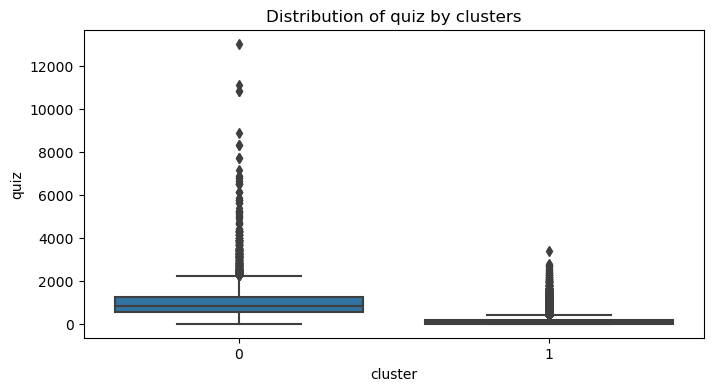

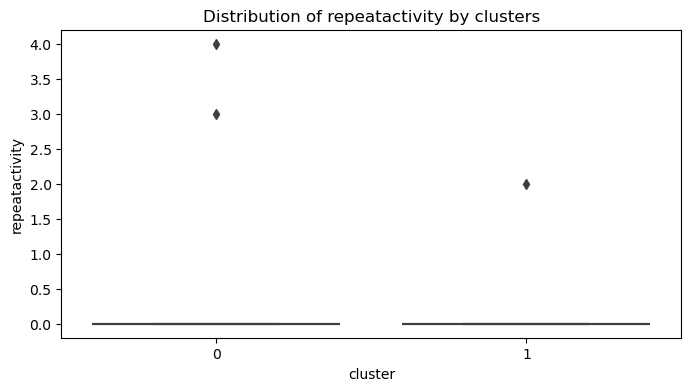

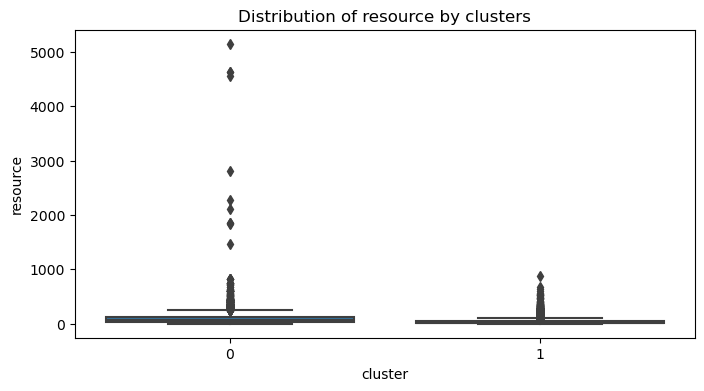

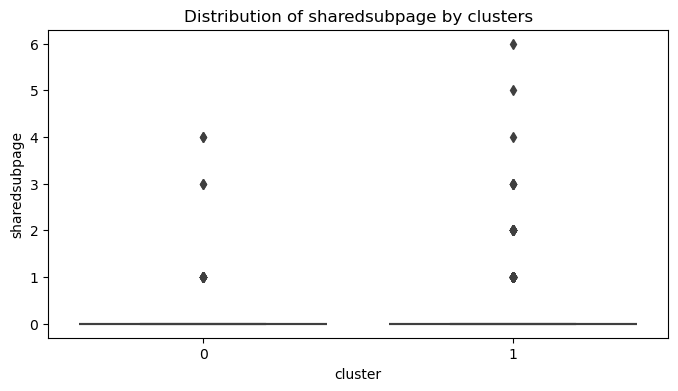

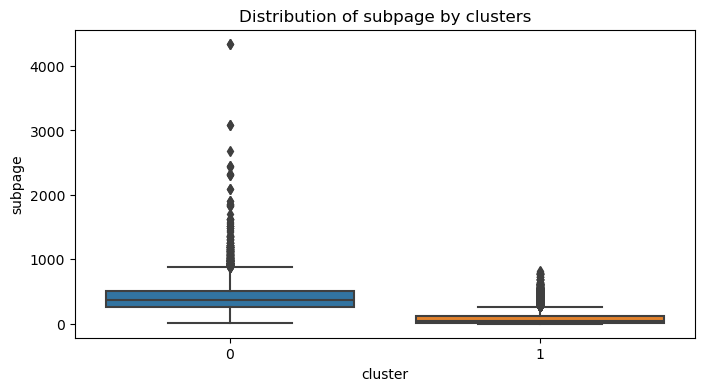

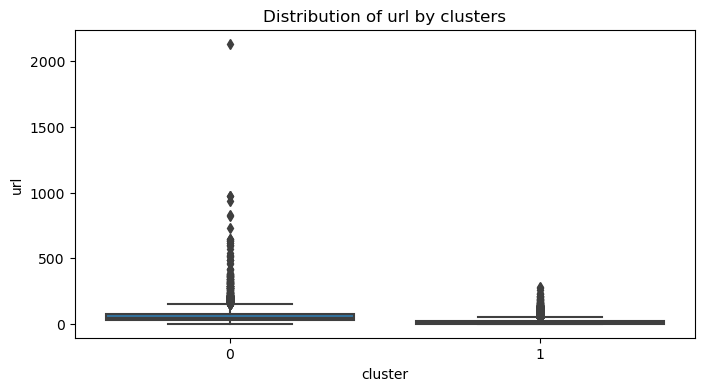

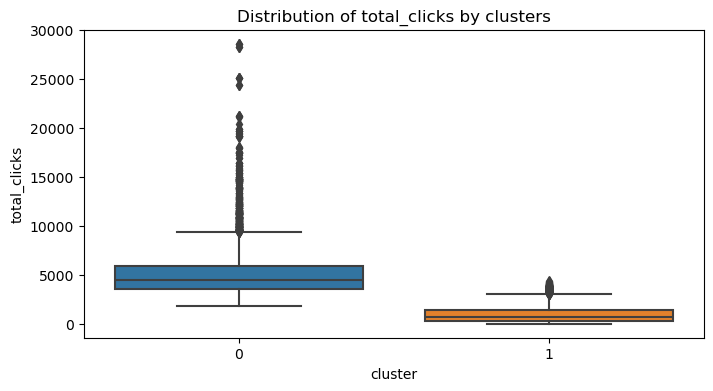

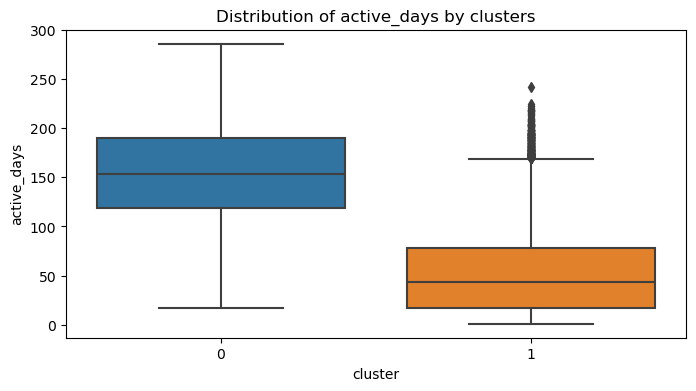

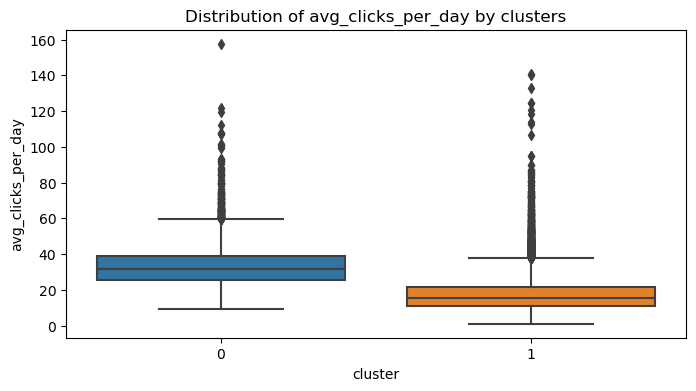

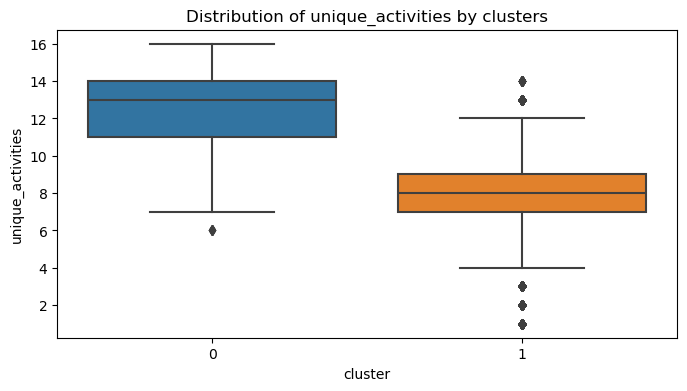

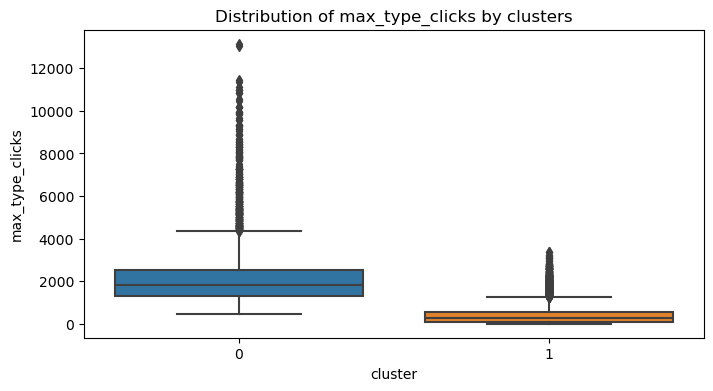

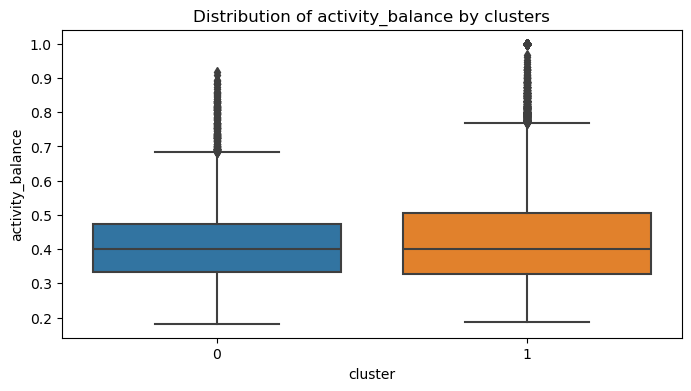

In [29]:
# 9. Cluster Analysis: Table of Average Features
cluster_means = features.groupby('cluster')[feature_cols].mean()
print("Average values ​​of features by clusters:\n", cluster_means)

# 10. Distribution of final results by clusters
result_by_cluster = features.groupby(['cluster', 'final_result']).size().unstack(fill_value=0)
print("Final results by clusters:\n", result_by_cluster)

# 11. Visualization of cluster characteristics(heatmap)
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Average values ​​of features for student clusters")
plt.show()

# 12. Boxplot for visual comparison of features across clusters
for col in feature_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=col, data=features)
    plt.title(f"Distribution of {col} by clusters")
    plt.show()

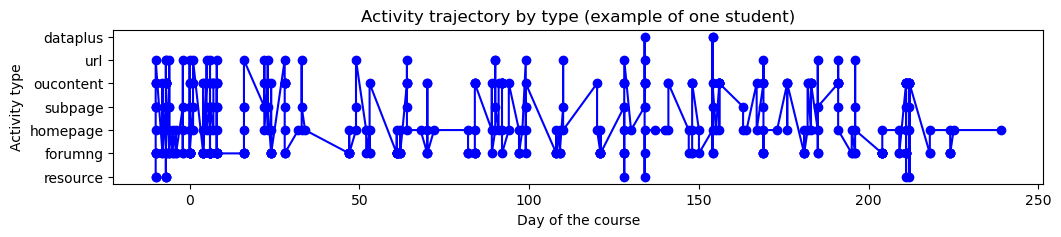

In [30]:
# For one student: sequence of activities over time
example_student = student_vle[student_vle['id_student'] == student_vle['id_student'].iloc[0]]
trajectory = example_student.sort_values('date')['activity_type'].tolist()
dates = example_student.sort_values('date')['date'].tolist()

plt.figure(figsize=(12,2))
plt.plot(dates, trajectory, marker='o', linestyle='-', color='blue')
plt.yticks(rotation=0)
plt.title("Activity trajectory by type (example of one student)")
plt.xlabel("Day of the course")
plt.ylabel("Activity type")
plt.show()


In [32]:
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

# For example - only one course (you can filter if you want)
df = student_vle.copy()
df['case:concept:name'] = df['id_student'].astype(str)
df['time:timestamp'] = pd.to_datetime(df['date'], errors='coerce') 
df['concept:name'] = df['activity_type']

# PM4Py wants at least three columns: case:concept:name (trace id), concept:name (activity), time:timestamp
log_df = df[['case:concept:name', 'concept:name', 'time:timestamp']].copy()
log_df = dataframe_utils.convert_timestamp_columns_in_df(log_df)

event_log = log_converter.apply(log_df)


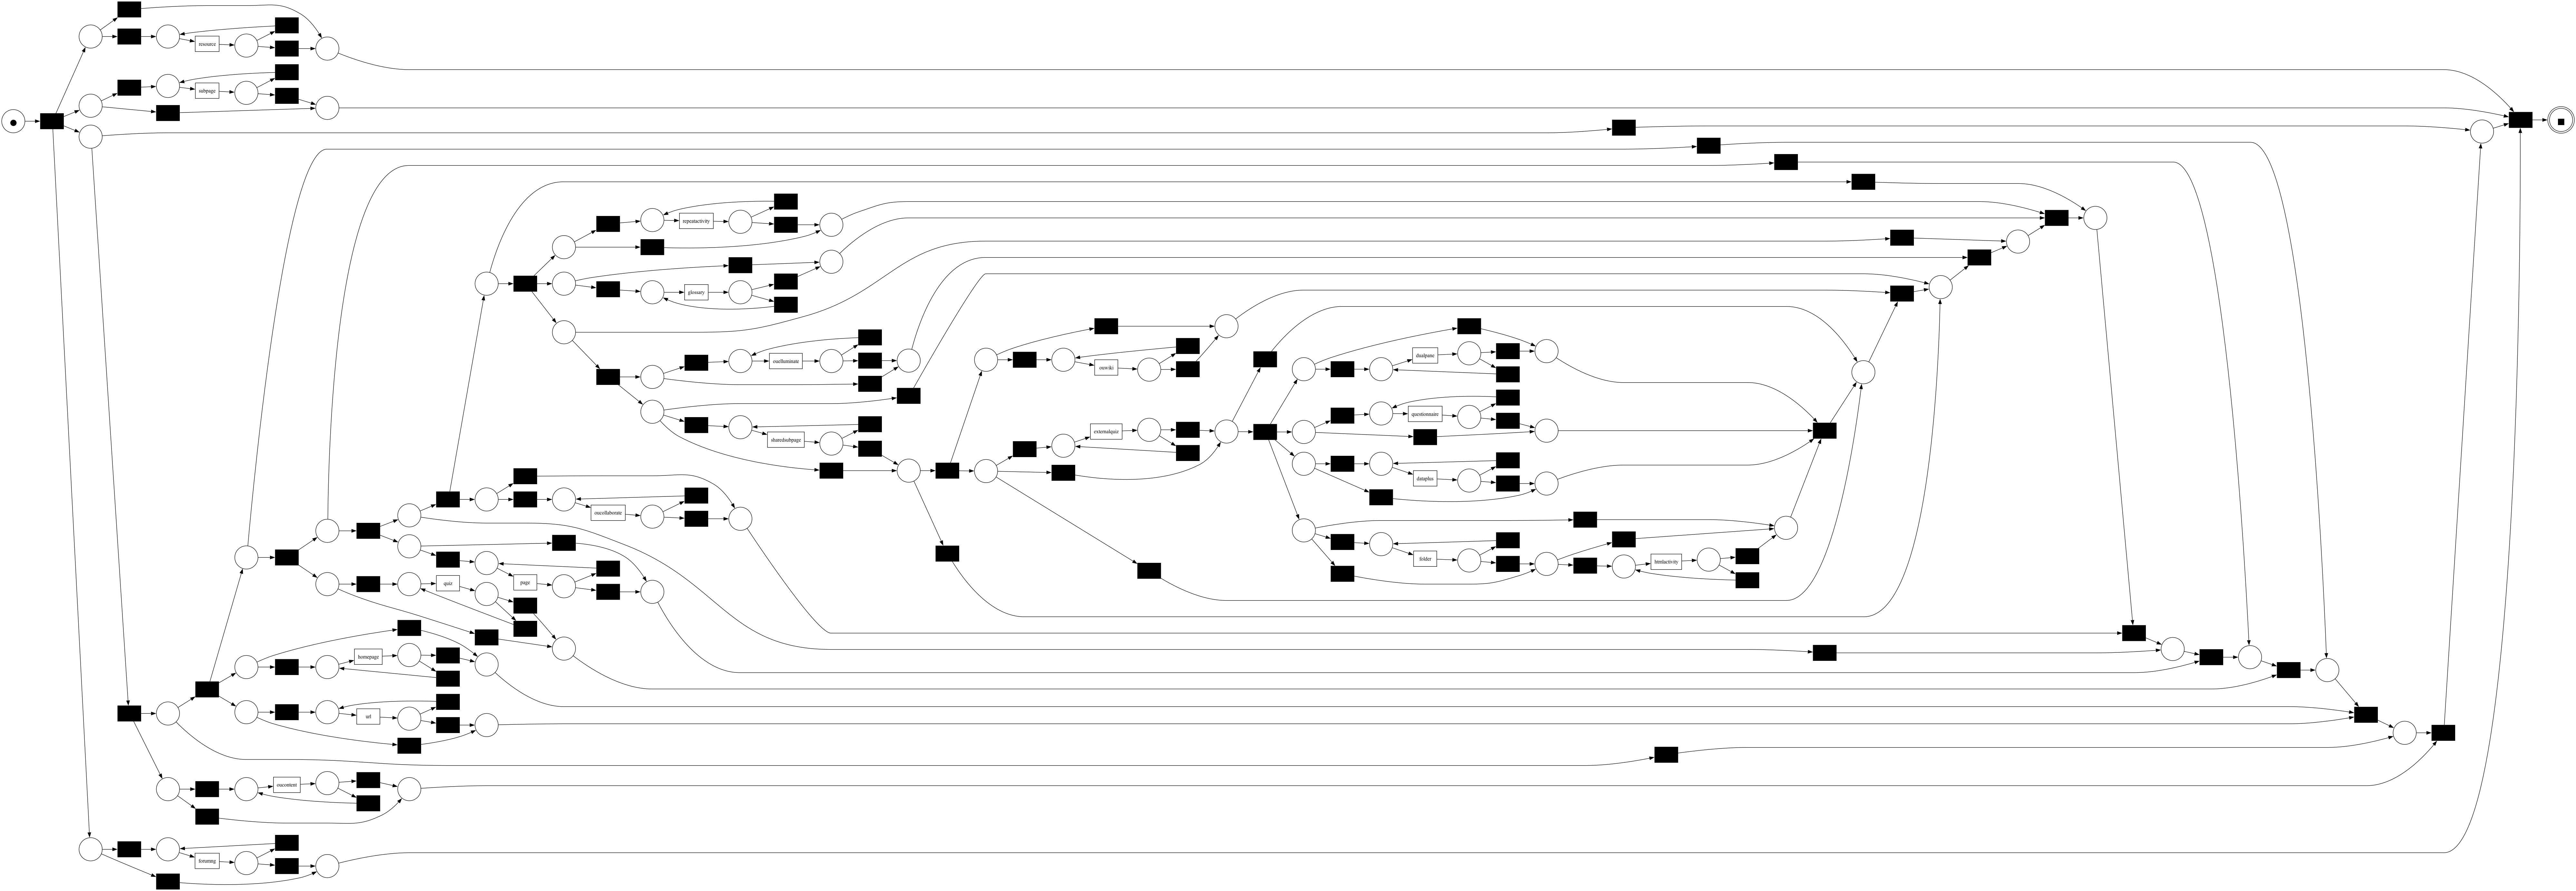

In [36]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# Получаем ProcessTree
process_tree = inductive_miner.apply(event_log, variant=inductive_miner.Variants.IMf)

# Конвертируем в Petri net
net, initial_marking, final_marking = pt_converter.apply(process_tree)

gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)


In [ ]:
cluster_id = 0
students_in_cluster = features[features['cluster'] == cluster_id]['id_student']
log_df_cluster = log_df[log_df['case:concept:name'].isin(students_in_cluster.astype(str))]
event_log_cluster = log_converter.apply(log_df_cluster)
net, initial_marking, final_marking = inductive_miner.apply(event_log_cluster)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

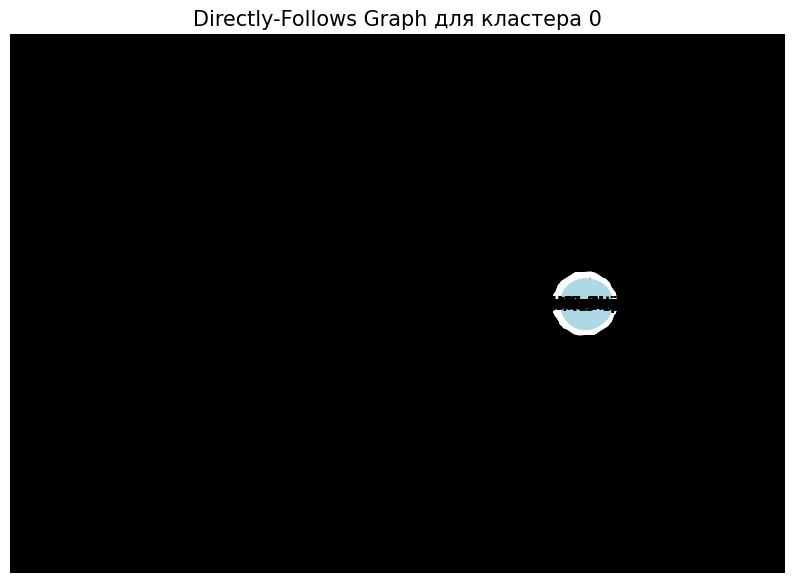

In [10]:
import networkx as nx
from collections import Counter

# Select students from the desired cluster (e.g. cluster 0)
cluster_id = 0
students_in_cluster = features[features['cluster'] == cluster_id]['id_student']

# Collect all sequences of cluster student activities
all_sequences = []
for sid in students_in_cluster:
    acts = student_vle[student_vle['id_student']==sid].sort_values('date')['activity_type'].tolist()
    if len(acts) > 1:
        all_sequences += [(acts[i], acts[i+1]) for i in range(len(acts)-1)]

# Calculate the number of transitions for DFG
dfg_counter = Counter(all_sequences)

# Создай граф
G = nx.DiGraph()
for (a_from, a_to), count in dfg_counter.items():
    G.add_edge(a_from, a_to, weight=count)

# Визуализация
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.8, seed=42)

# Рёбра: толщину — по количеству переходов
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1200)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=[w*0.2 for w in weights], arrows=True, arrowstyle='->', arrowsize=25)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u,v): G[u][v]['weight'] for u,v in edges}, font_color='red')

plt.title(f'Directly-Follows Graph для кластера {cluster_id}', fontsize=15)
plt.axis('off')
plt.show()
